## The Strategy

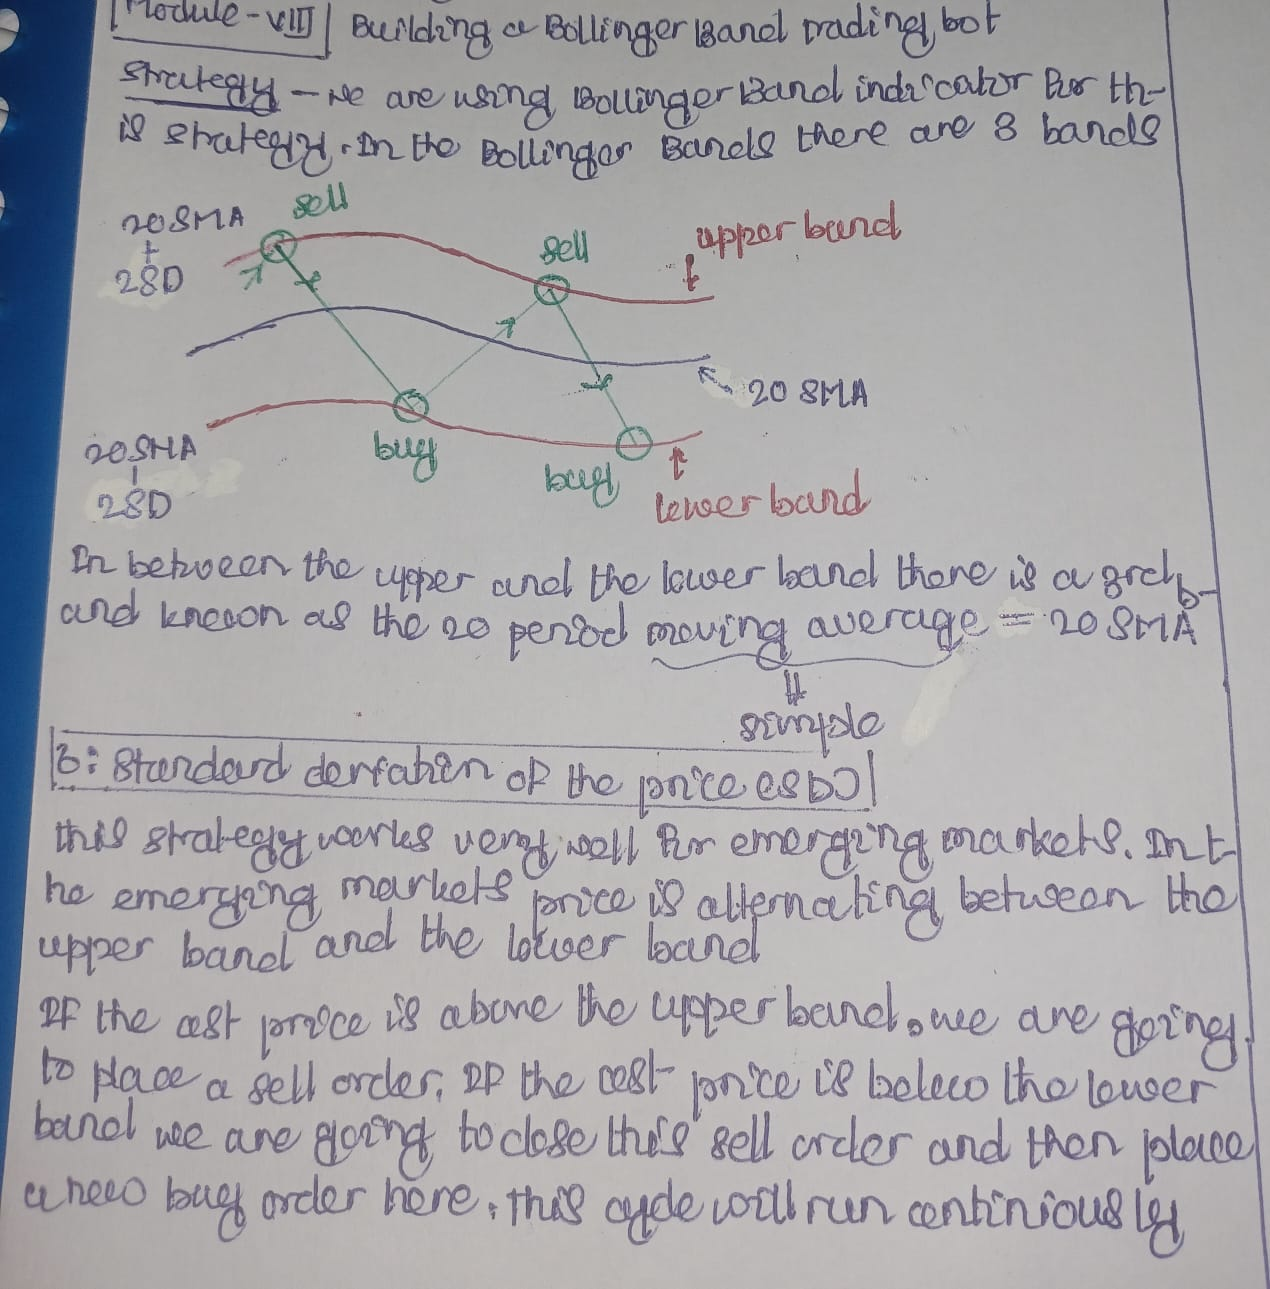

## Assembling the Bot

In [1]:
## import the libraries
import MetaTrader5 as mt5
import pandas as pd

In [2]:
## trading parameters
symbol = "EURUSD"
sma_preiod = 20
timeframe = mt5.TIMEFRAME_M1
volume = 0.05

In [3]:
## connect with python
mt5.initialize(login = 51386052, server = "ICMarketsSC-Demo", password ="8ZahZUPE")

True

In [4]:
## function to place market order
def market_order(symbol, volume, order_type):
    tick = mt5.symbol_info_tick(symbol)
    order_dict = {'buy': 0, 'sell': 1}
    price_dict = {'buy': tick.ask, 'sell': tick.bid}

    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume,
        "type": order_dict[order_type],
        "price": price_dict[order_type],
        "deviation": 20,
        "magic": 100,
        "comment": "python market order",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }

    order_result = mt5.order_send(request)
    print(order_result)
    return order_result

In [5]:
## function to close a position
def close_position(position):
    tick = mt5.symbol_info_tick(position.symbol)

    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "position": position.ticket,
        "symbol": position.symbol,
        "volume": position.volume,
        "type": mt5.ORDER_TYPE_BUY if position.type == 1 else mt5.ORDER_TYPE_SELL,
        "price": tick.ask if position.type == 1 else tick.bid,
        "deviation": 20,
        "magic": 100,
        "comment": "python script close",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }

    result = mt5.order_send(request)
    return result

In [6]:
## function to calculate the direction
def cal_direction(symbol, sma_period, timeframe):
    candles = mt5.copy_rates_from_pos(symbol, timeframe, 1, sma_period)
    candles_df = pd.DataFrame(candles)
    last_close = candles_df.iloc[-1].close
    sma = candles_df.close.mean()
    sd = candles_df.close.std()
    upper_band = sma + (2 * sd)
    lower_band = sma - (2 * sd)
    if last_close > upper_band:
        return "sell"
    if last_close < lower_band:
        return  "buy"
    if upper_band > last_close > lower_band:
        return "neutral"

In [7]:
## driver code
while True:
    direction = cal_direction(symbol, sma_preiod, timeframe)
    if direction == "buy":
        for position in mt5.positions_get(symbol = symbol):
            if position.type == 1:
                close_position(position)
        if not mt5.positions_total():
            market_order(symbol, volume, direction)

    if direction == "sell":
        for position in mt5.positions_get(symbol = symbol):
            if position.type == 0:
                close_position(position)
        if not mt5.positions_total():
            market_order(symbol, volume, direction)

OrderSendResult(retcode=10009, deal=350494965, order=482891783, volume=0.05, price=1.06623, bid=1.06617, ask=1.06623, comment='Request executed', request_id=2700734177, retcode_external=0, request=TradeRequest(action=1, magic=100, order=0, symbol='EURUSD', volume=0.05, price=1.06623, stoplimit=0.0, sl=0.0, tp=0.0, deviation=20, type=0, type_filling=1, type_time=0, expiration=0, comment='python market order', position=0, position_by=0))


KeyboardInterrupt: 

## Testing the Bot

Let's run the above code and wait for some time to see what happens. We will stop the bot and close the current position.